In [259]:
#Reference: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
#Dataset: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset

# Imports needed for the script
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
#  Display outputs of multiple commands from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [260]:
# Loading the data
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Files/Titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Files/Titanic/test.csv')


In [315]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [317]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [261]:
# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [262]:
#The class Survived is already in binary format so no additional formatting is necessary, 
#but features like Name, Ticket or Cabin need to be adapted for the problem we're trying to solve, 
#and we can also engineer some new features by merging or regrouping existing ones. 
#Reference: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset

######### Important
# Copy original dataset in case we need it later when digging into interesting features
# WARNING: Beware of actually copying the dataframe instead of just referencing it
# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')

original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values


In [263]:
#Feature Engineering
#Reference: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
# https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
# https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
# https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic

full_data1 = [train, test]

full_data = pd.concat(full_data1)

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [264]:
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [88]:
full_data.shape

(1309, 14)

In [174]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [265]:
# Create new feature FamilySize as a combination of SibSp and Parch
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [266]:
# Create new feature IsAlone from FamilySize
#print (full_data['FamilySize'][full_data['FamilySize'] == 1])
full_data['IsAlone']=0
full_data.loc[full_data['FamilySize'] == 1, 'IsAlone'] = 1

print (full_data['IsAlone'][full_data['FamilySize'] == 2])
full_data.head()

0      0
1      0
3      0
9      0
18     0
      ..
401    0
402    0
404    0
406    0
411    0
Name: IsAlone, Length: 235, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1


In [267]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Has_Cabin        0
dtype: int64

In [248]:
test.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
Has_Cabin         0
FamilySize        0
IsAlone           0
dtype: int64

In [268]:
full_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
FamilySize        0
IsAlone           0
dtype: int64

In [269]:
#Remove nulls from dataset

# Check the values in Embarked Column
print (full_data['Embarked'].unique())
print (full_data['Embarked'].value_counts())

['S' 'C' 'Q' nan]
S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [270]:
# Remove all NULLS in the Embarked column
full_data['Embarked'] = full_data['Embarked'].fillna('S')

(array([1070.,  154.,   42.,    4.,   21.,   13.,    0.,    0.,    0.,
           4.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 10 Patch objects>)

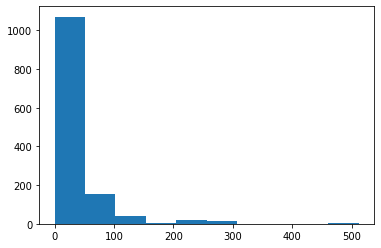

In [164]:
#Check Fare column
plt.hist(full_data['Fare'])

In [271]:
# Remove all NULLS in the Fare column
full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].median())

In [193]:
#Check Fare column
full_data["Fare"].value_counts()

8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
33.5000     1
7.8000      1
26.3875     1
15.5792     1
7.1417      1
Name: Fare, Length: 281, dtype: int64

(array([ 72.,  62., 274., 250., 161., 108.,  65.,  41.,  10.,   3.]),
 array([ 0.17 ,  8.153, 16.136, 24.119, 32.102, 40.085, 48.068, 56.051,
        64.034, 72.017, 80.   ]),
 <a list of 10 Patch objects>)

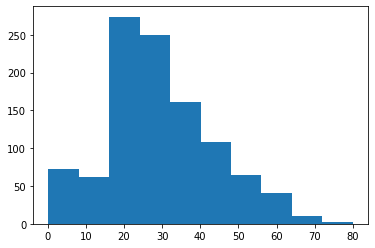

In [194]:
#Check Age Column
plt.hist(full_data['Age'])

In [274]:
full_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
IsAlone           0
dtype: int64

In [199]:
#test = full_data.copy()

In [252]:
# Remove all NULLS in the Age column
#test['Age'] = test['Age'].fillna(int(test['Age'].mean()))

In [200]:
#import random
#test['Age'].fillna(random.choice(test['Age'][test['Age'].notna()]))

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
413    17.0
414    39.0
415    38.5
416    17.0
417    17.0
Name: Age, Length: 1309, dtype: float64

In [276]:
#Filling null values in age column
import random
full_data['Age'] = full_data['Age'].fillna(random.choice(full_data['Age'][full_data['Age'].notna()]))

In [257]:
full_data['Age'].value_counts()

24.00    77
22.00    70
21.00    65
30.00    65
18.00    65
         ..
76.00     1
0.33      1
60.50     1
0.17      1
26.50     1
Name: Age, Length: 98, dtype: int64

In [277]:
#Checking Survived column
# Check the values in Embarked Column
print (full_data['Survived'].unique())
print (full_data['Survived'].value_counts())

[ 0.  1. nan]
0.0    549
1.0    342
Name: Survived, dtype: int64


In [207]:
#Remove all nulls from the Survived column
#import random
#full_data['Survived'].fillna(random.choice(full_data['Survived'][full_data['Survived'].notna()]), inplace=True)

In [208]:
#print (full_data['Survived'].unique())
#print (full_data['Survived'].value_counts())

[0. 1.]
1.0    760
0.0    549
Name: Survived, dtype: int64


In [209]:
#Check Cabin Column
print (full_data['Cabin'].unique())
print (full_data['Cabin'].value_counts())

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148' 'B45' 'B36' 'A21' 'D34' 'A9' 'C31' 'B61' 'C5

In [279]:
#Fill missing values in cabin with random values from the cabin values
full_data['Cabin'].fillna(random.choice(full_data['Cabin'][full_data['Cabin'].notna()]), inplace=True)

In [280]:
#Check again if any more null values are remaining
full_data.isna().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
FamilySize       0
IsAlone          0
dtype: int64

In [218]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [120]:
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,29.881138,1,0,A/5 21171,7.2500,B57 B59 B63 B66,S,0,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,29.881138,1,0,PC 17599,71.2833,C85,C,1,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,29.881138,0,0,STON/O2. 3101282,7.9250,B57 B59 B63 B66,S,0,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,29.881138,1,0,113803,53.1000,C123,S,1,2,0
4,5,0.0,3,"Allen, Mr. William Henry",male,29.881138,0,0,373450,8.0500,B57 B59 B63 B66,S,0,1,1


In [281]:
#Feature Engineering on 
full_data['Title'] = full_data['Name'].apply(get_title)
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,C83,S,2,0,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,C83,S,1,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,C83,S,1,1,Mr


In [282]:
# Group all non-common titles into one single grouping "Rare"
full_data['Title'] = full_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'OtherTitle')

full_data['Title'] = full_data['Title'].replace('Mlle', 'Miss')
full_data['Title'] = full_data['Title'].replace('Ms', 'Miss')
full_data['Title'] = full_data['Title'].replace('Mme', 'Mrs')

In [222]:
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,A19,S,0,2,0,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,A19,S,0,1,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,0,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,A19,S,0,1,1,Mr


In [283]:
#Encoding the values

# Mapping Sex
full_data['Sex'] = full_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
# Mapping titles
title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "OtherTitle": 5}
full_data['Title'] = full_data['Title'].map(title_mapping)
full_data['Title'] = full_data['Title'].fillna(0)

# Mapping Embarked
full_data['Embarked'] = full_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
# Mapping Fare
full_data.loc[ full_data['Fare'] <= 7.91, 'Fare']= 0
full_data.loc[(full_data['Fare'] > 7.91) & (full_data['Fare'] <= 14.454), 'Fare'] = 1
full_data.loc[(full_data['Fare'] > 14.454) & (full_data['Fare'] <= 31), 'Fare']   = 2
full_data.loc[ full_data['Fare'] > 31, 'Fare']= 3
full_data['Fare'] = full_data['Fare'].astype(int)
    
# Mapping Age
full_data.loc[ full_data['Age'] <= 16, 'Age']= 0
full_data.loc[(full_data['Age'] > 16) & (full_data['Age'] <= 32), 'Age'] = 1
full_data.loc[(full_data['Age'] > 32) & (full_data['Age'] <= 48), 'Age'] = 2
full_data.loc[(full_data['Age'] > 48) & (full_data['Age'] <= 64), 'Age'] = 3
full_data.loc[ full_data['Age'] > 64, 'Age'] ;

In [284]:
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,0,C83,0,2,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,PC 17599,3,C85,1,2,0,3
2,3,1.0,3,"Heikkinen, Miss. Laina",0,1.0,0,0,STON/O2. 3101282,1,C83,0,1,1,4
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,113803,3,C123,0,2,0,3
4,5,0.0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,1,C83,0,1,1,1


In [290]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
full_data = full_data.drop(drop_elements, axis = 1)

KeyError: ignored

In [289]:
full_data.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,FamilySize,IsAlone,Title
0,0.0,3,1,1.0,0,0,0,2,0,1
1,1.0,1,0,2.0,0,3,1,2,0,3
2,1.0,3,0,1.0,0,1,0,1,1,4
3,1.0,1,0,2.0,0,3,0,2,0,3
4,0.0,3,1,2.0,0,1,0,1,1,1


In [323]:
#Split the dataset into train and test 
test = full_data[pd.isna(full_data['Survived'])==True]

In [295]:
train = full_data[pd.isna(full_data['Survived'])==False]

In [296]:
train.shape
test.shape

(891, 10)

(418, 10)

In [324]:
test.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,FamilySize,IsAlone,Title
0,NaN,3,1,2.0,0,0,2,1,1,1
1,NaN,3,0,2.0,0,0,0,2,0,3
2,NaN,2,1,3.0,0,1,2,1,1,1
3,NaN,3,1,1.0,0,1,0,1,1,1
4,NaN,3,0,1.0,1,1,0,3,0,3


<Figure size 864x864 with 0 Axes>

Text(0.5, 1.05, 'Pearson Correlation of Features')

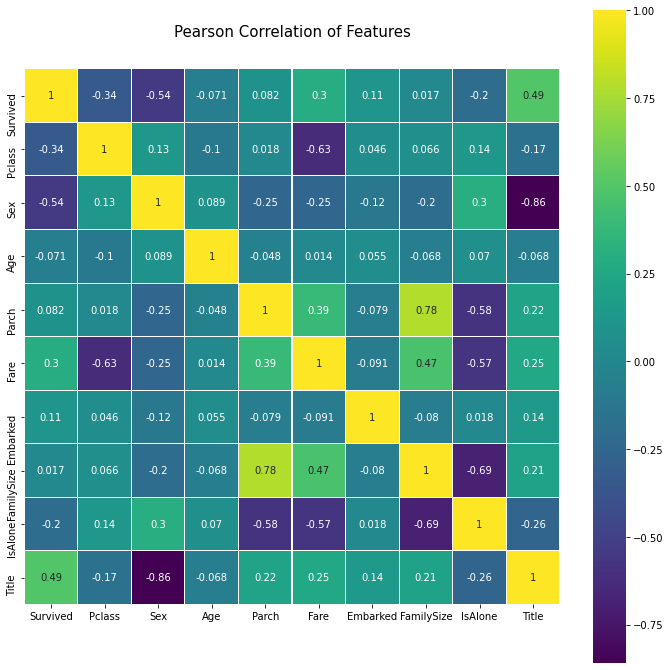

In [297]:
#Visualising processed data
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [299]:
#Comparing betwee features to understand relationship
#Title VS Sex
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "OtherTitle": 5} 

Survived             
           mean count    sum
Title                       
1      0.156673   517   81.0
2      0.575000    40   23.0
3      0.793651   126  100.0
4      0.702703   185  130.0
5      0.347826    23    8.0

In [300]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived             
         mean count    sum
Sex                       
0    0.742038   314  233.0
1    0.188908   577  109.0

We find that, excepting for a single observation (a female with 'Dr' title), all the observations for a given Title share the same Sex. Therefore the feature Title is capturing all the information present in Sex. In addition, Title may be more valuable to our task by capturing other characteristics of the individuals like age, social class, personality, ...

It's true that by regrouping rare titles into a single category, we are losing some information regarding Sex.

In [301]:
# Let's use our 'original_train' dataframe to check the sex distribution for each title.
# We use copy() again to prevent modifications in out original_train dataset
title_and_sex = original_train.copy()[['Name', 'Sex']]

# Create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

# Map 'Sex' as binary feature
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Sex is a binary feature, this metrics grouped by the Title feature represent:
    # MEAN: percentage of men
    # COUNT: total observations
    # SUM: number of men

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

In [231]:
#Gini Impurity

# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [302]:
print (train['Survived'].value_counts())

0.0    549
1.0    342
Name: Survived, dtype: int64


In [303]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891) #Since only 342 observations survived, the survival probability is around 38.38% (342/891).
gini_impurity_starting_node

0.47301295786144265



We're now going to simulate both splits, calculate the impurity of resulting nodes and then obtain the weighted Gini Impurity after the split to measure how much each split has actually reduced impurity.

If we split by Sex, we'll have the two following nodes:

Node with men: 577 observations with only 109 survived

Node with women: 314 observations with 233 survived



In [305]:
# Gini Impurity increase of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [304]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [309]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214



If we split by Title == 1 (== Mr), we'll have the two following nodes:

Node with only Mr: 517 observations with only 81 survived

Node with other titles: 374 observations with 261 survived



In [308]:
# Gini Impurity decrease of node for observations with Title == 1 == Mr
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [307]:
# Gini Impurity decrease if node splited for observations with Title != 1 != Mr
gini_impurity_title_others = get_gini_impurity(374, 261)
gini_impurity_title_others

-1.2407921199042884

In [311]:
# Gini Impurity decrease if node splited for observations with Title == 1 == Mr
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.8405071187274711

We find that the Title feature is slightly better at reducing the Gini Impurity than Sex. This confirms our previous analysis, and we're now sure that Title will be used for the first split. Sex will therefore be neglected since the information is already included in the Title feature.

In [312]:
#Finding best tree depth with the help of Cross Validation
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

#The best max_depth parameter seems therefore to be 4 (82.94% average accuracy across the 10 folds), and feeding the model with more data results in worst results probably due to over-fitting.
# We'll therefore use 3 as the max_depth parameter for our final model.

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.829413
         5          0.819326
         6          0.812647
         7          0.794644
         8          0.801373
         9          0.804794
        10          0.799164


In [336]:
#Final Tree
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.drop(['Survived'], axis=1).values

# Create Decision Tree with max_depth = 4
decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
decision_tree.fit(x_train, y_train)



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [337]:
# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)

0

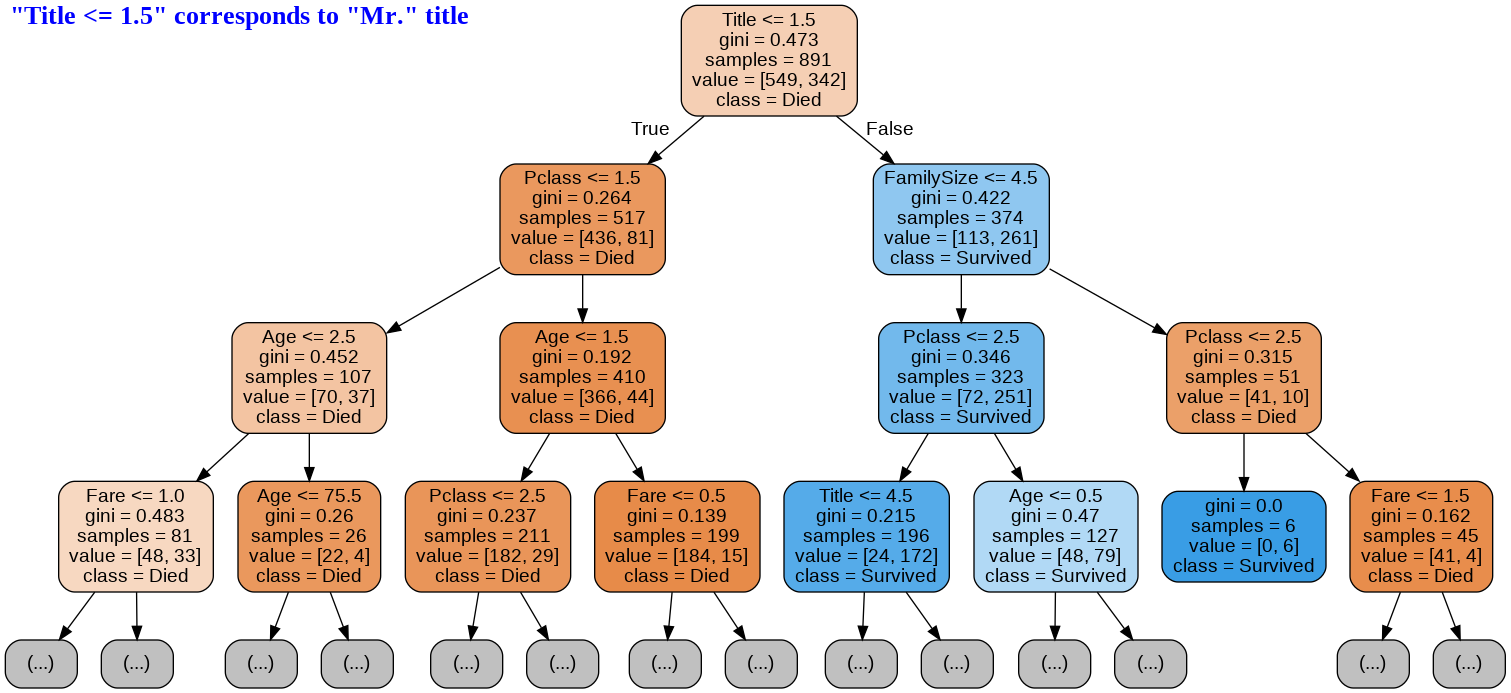

In [338]:
# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

# Code to check available fonts and respective paths
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [339]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

83.39

#Observations by the writer

The first line of each node (except those of the final row) shows the splitting condition in the form "feature <= value".

Next, we find the Gini Impurity of the node, already explained in this kernel. "Samples" is simply the number of observations contained in the node.

"Value" shows the class distribution of the samples ([count non_survived, count survived]).

Lastly, "class" correspond to the predominant class of each node, and this is how our model will classify an observation. The colour also represents the class, the opacity increasing with the actual distribution of samples.

Our model can therefore be summarised with 4 simple rules:

* If our observation includes de "Mr" Title, then we classify it as not survived (all the branches in the left side of the tree lead to an orange node)
* If it doesn't include "Mr" Title, and FamilySize is 4 or less, then we classify it as survived.
* If it doesn't include "Mr" Title, FamilySize is more than 4 and Pclass is 2 or less, then we classify it as survived.
* If it doesn't include "Mr" Title, FamilySize is more than 4 and Pclass is more than 2, then we classify it as not survived.

Thanks to these rules we can infer some insights about the shipwreck. "Misters" seem to have honoured their title and sacrificed themselves in favour on women and men with more exotic titles like "Master" or "Dr". We can also note that smaller families had better chances to survive, maybe because bigger families tried to stick together or look for missing members and therefore didn't had places left in the lifeboats. Finally, we can observe that 3rd class passengers had also less chances to survive so probably passengers belonging to upper social social classes were privileged, or simply 3rd class cabins may have been further away of the lifeboats.

In [330]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [341]:
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.drop(['Survived'], axis=1).values

In [342]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=1) # 70% training and 30% test

In [343]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [344]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7873134328358209


In [345]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[133  20]
 [ 37  78]]


In [346]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred)

0.7323943661971831

In [347]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82       153
         1.0       0.80      0.68      0.73       115

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.79      0.79      0.78       268



Text(0.5, 1.0, 'Receiver Operating Characteristic')

(0.0, 1.0)

(0.0, 1.0)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

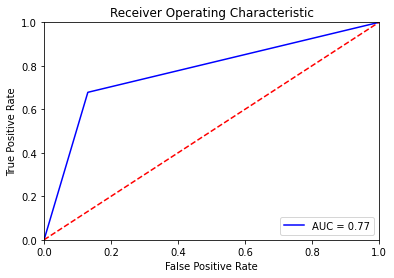

In [348]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Reference: https://www.kaggle.com/usengecoder/performance-metrics-for-classification-problems

In [349]:
#Log Loss
#Reference: https://www.kaggle.com/usengecoder/performance-metrics-for-classification-problems

from sklearn.metrics import log_loss
log_loss(y_test,y_pred)

#For any given problem, a lower log loss value means better predictions


7.3459934569347505

<Figure size 2160x1080 with 0 Axes>

[Text(837.0, 733.86, 'X[8] <= 1.5\ngini = 0.463\nsamples = 623\nvalue = [396, 227]'),
 Text(383.625, 570.78, 'X[0] <= 1.5\ngini = 0.224\nsamples = 365\nvalue = [318, 47]'),
 Text(209.25, 407.70000000000005, 'X[2] <= 75.5\ngini = 0.417\nsamples = 71\nvalue = [50, 21]'),
 Text(139.5, 244.62, 'X[2] <= 2.5\ngini = 0.408\nsamples = 70\nvalue = [50, 20]'),
 Text(69.75, 81.54000000000008, 'gini = 0.449\nsamples = 53\nvalue = [35, 18]'),
 Text(209.25, 81.54000000000008, 'gini = 0.208\nsamples = 17\nvalue = [15, 2]'),
 Text(279.0, 244.62, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(558.0, 407.70000000000005, 'X[2] <= 1.5\ngini = 0.161\nsamples = 294\nvalue = [268, 26]'),
 Text(418.5, 244.62, 'X[7] <= 0.5\ngini = 0.219\nsamples = 152\nvalue = [133, 19]'),
 Text(348.75, 81.54000000000008, 'gini = 0.069\nsamples = 28\nvalue = [27, 1]'),
 Text(488.25, 81.54000000000008, 'gini = 0.248\nsamples = 124\nvalue = [106, 18]'),
 Text(697.5, 244.62, 'X[4] <= 0.5\ngini = 0.094\nsamples = 142\nvalue = [

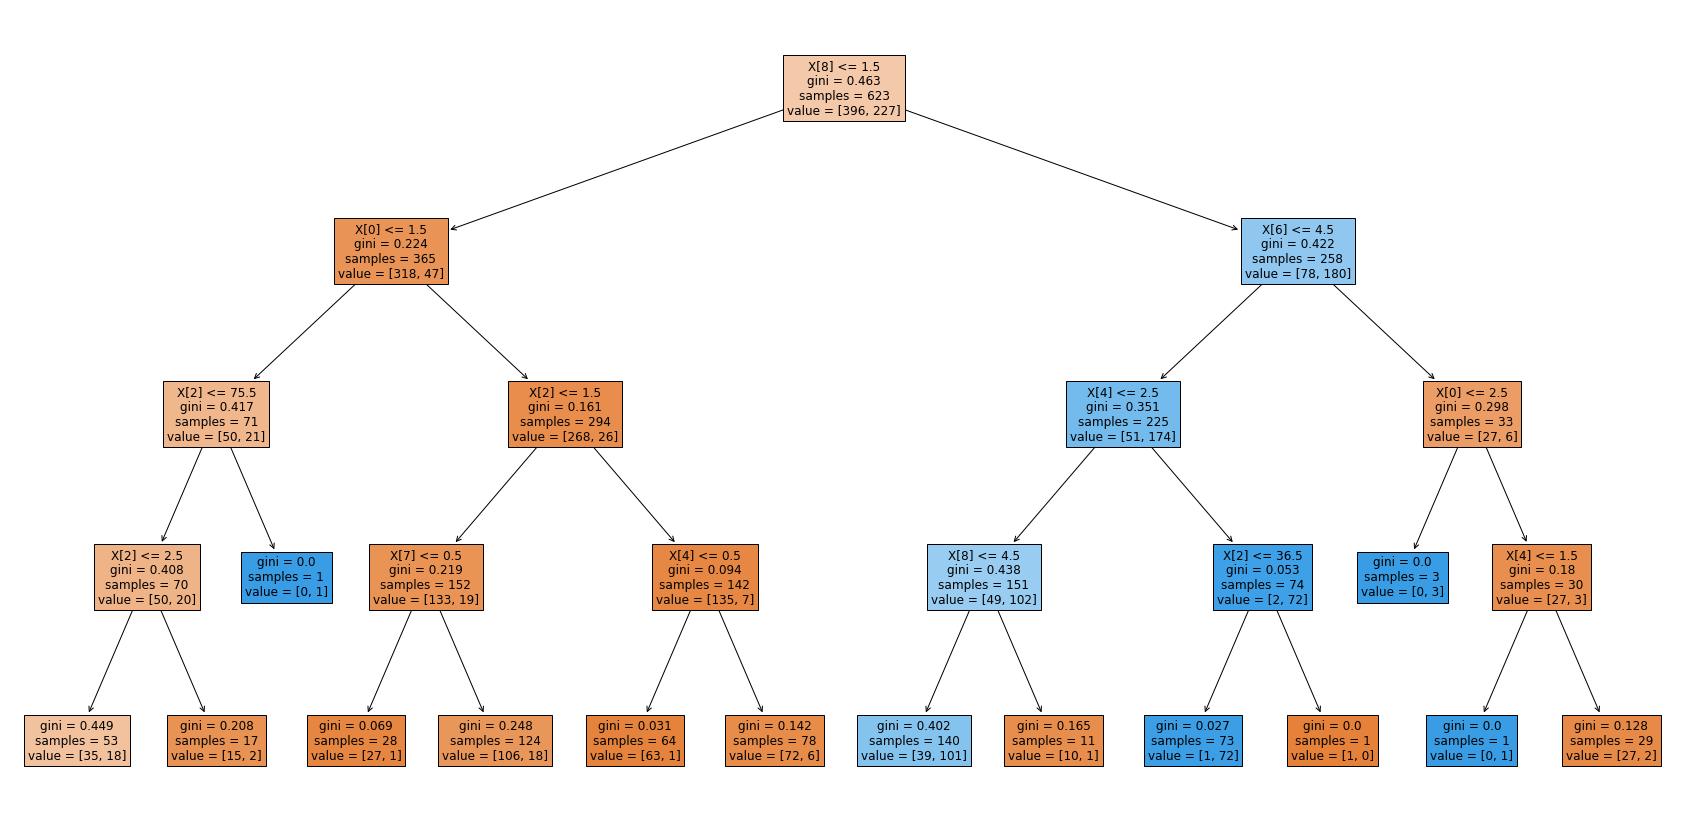

In [353]:
from sklearn import tree
plt.figure(figsize=(30,15))
tree.plot_tree(clf, filled=True, fontsize=12)